# Recurrent Neural Network Model

This is the RNN model notebook for the Solar intensity forecasting project. <br>
Andres Aguilar <br>
Martijjn de Vries <br>
William Lopez

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

2023-05-17 15:42:10.629003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martijndevries/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Let's read in the data that we made in the from the data collection notebook

In [2]:
df = pd.read_csv('../data/NSRDB_data.csv')

In [3]:
num_features = ['Wind Speed', 'Wind Direction', 'Dew Point', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']

cloudtypes = to_categorical(df['Cloud Type'])

month = to_categorical(df['Month'])

hour = to_categorical(df['Hour'])

In [14]:
stacked_data = np.hstack([df[num_features].values, df[['GHI']].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
stacked_tot = np.hstack([stacked_sc[:,:-1], cloudtypes[:,:], month[:,:], hour[:,:], stacked_sc[:,-1:]])

Now I want to sequence the data, so that n_in timesteps align with the same number of timesteps. This code was largely copied from 
https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [15]:
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

For the train test split, I will use the last 

In [16]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 54), (62400, 24), (25082, 192, 54), (25082, 24))

In [17]:
###THIS MODEL WORKS

#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
# define model
model = Sequential()
#model.add(BatchNormalization())
model.add(Dropout(0.23))
model.add(GRU(34, activation='relu', return_sequences=True, input_shape=(n_steps_in, nr_features)))
model.add(Dropout(0.18))
model.add(GRU(34, activation='relu', kernel_regularizer=l2(0.01)))
#model.add(BatchNormalization())
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [18]:
# Fit network
history = model.fit(train_X , train_y , batch_size=200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
312/312 [==============================] - 41s 128ms/step - loss: 0.7792 - r_square: 0.4723 - val_loss: 0.7929 - val_r_square: 0.3084
Epoch 2/90
312/312 [==============================] - 38s 122ms/step - loss: 0.2685 - r_square: 0.8160 - val_loss: 0.4298 - val_r_square: 0.6242
Epoch 3/90
312/312 [==============================] - 38s 121ms/step - loss: 0.1830 - r_square: 0.8692 - val_loss: 0.2611 - val_r_square: 0.7767
Epoch 4/90
312/312 [==============================] - 38s 121ms/step - loss: 0.1506 - r_square: 0.8870 - val_loss: 0.1994 - val_r_square: 0.8283
Epoch 5/90
312/312 [==============================] - 38s 122ms/step - loss: 0.1321 - r_square: 0.8963 - val_loss: 0.1678 - val_r_square: 0.8531
Epoch 6/90
312/312 [==============================] - 38s 121ms/step - loss: 0.1194 - r_square: 0.9028 - val_loss: 0.1500 - val_r_square: 0.8661
Epoch 7/90
312/312 [==============================] - 38s 121ms/step - loss: 0.1094 - r_square: 0.9085 - val_loss: 0.1376 - val_r_

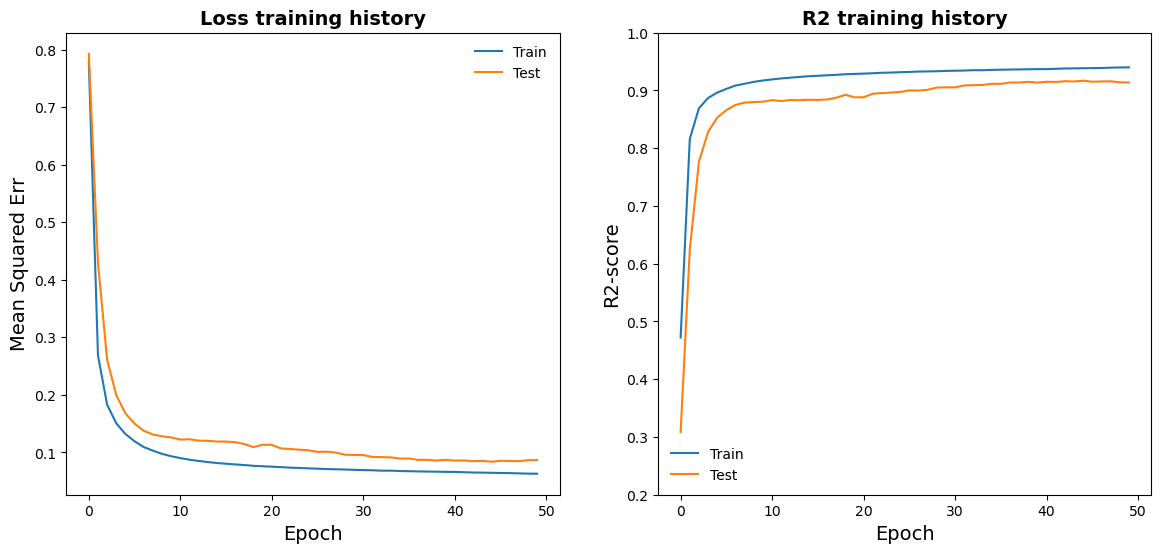

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Test')
ax1.legend(frameon=False)
#ax1.set_ylim(0, 25000)
ax1.set_ylabel('Mean Squared Err', fontsize=14)

ax1.set_xlabel('Epoch', fontsize=14)

ax1.set_title('Loss training history', fontweight='bold', fontsize=14)
ax2.plot(history.history['r_square'], label='Train')
ax2.plot(history.history['val_r_square'], label='Test')
ax2.legend(frameon=False)
ax2.set_title('R2 training history',  fontweight='bold', fontsize=14)
ax2.set_ylim(0.2, 1)
ax2.set_ylabel('R2-score', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
plt.show()

In [20]:
preds_train = model.predict(train_X)

1950/1950 [==============================] - 31s 16ms/step


In [21]:
preds_test = model.predict(test_X)

784/784 [==============================] - 13s 16ms/step


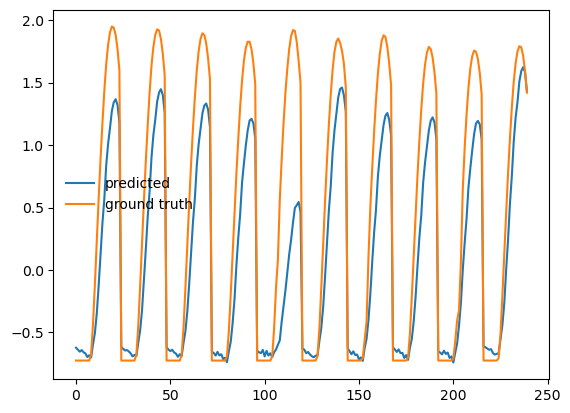

In [22]:
preds_l, test_l = [], []
x = 5
for i in range(70, 80):
    preds_l += list(preds_test[i*48+x,:])
    test_l += list(test_y[i*48+x,:])
plt.plot(preds_l, label='predicted')
plt.plot(test_l, label='ground truth')
plt.legend(frameon=False)

Let's try with PolynomialFeatures for hte numerical columns

In [34]:
num_features = ['Wind Speed', 'Wind Direction', 'Dew Point', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']

cloudtypes = to_categorical(df['Cloud Type'])

month = to_categorical(df['Month'])

hour = to_categorical(df['Hour'])

In [35]:
pf = PolynomialFeatures()
data_pf = pf.fit_transform(df[num_features])

stacked_data = np.hstack([data_pf, df[['GHI']].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
stacked_tot = np.hstack([stacked_sc[:,:-1], cloudtypes[:,:], month[:,:], hour[:,:], stacked_sc[:,-1:]])

In [36]:
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 192, 24
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [38]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 83), (62400, 24), (25082, 192, 83), (25082, 24))

In [39]:
###THIS MODEL WORKS

#optimizer learning rate
opt = Nadam(learning_rate=0.0005)
es = EarlyStopping(patience=5)
# define model
model = Sequential()
#model.add(BatchNormalization())
model.add(Dropout(0.23))
model.add(GRU(34, activation='relu', return_sequences=True, input_shape=(n_steps_in, nr_features)))
model.add(Dropout(0.18))
model.add(GRU(34, activation='relu', kernel_regularizer=l2(0.01)))
#model.add(BatchNormalization())
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [40]:
# Fit network
history_pf = model.fit(train_X , train_y , batch_size=200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
312/312 [==============================] - 45s 139ms/step - loss: 0.7144 - r_square: 0.5308 - val_loss: 1.2325 - val_r_square: -0.1456
Epoch 2/90
312/312 [==============================] - 40s 130ms/step - loss: 0.2786 - r_square: 0.8026 - val_loss: 0.6053 - val_r_square: 0.4422
Epoch 3/90
312/312 [==============================] - 41s 131ms/step - loss: 0.2015 - r_square: 0.8491 - val_loss: 0.4411 - val_r_square: 0.5918
Epoch 4/90
312/312 [==============================] - 41s 132ms/step - loss: 0.1576 - r_square: 0.8792 - val_loss: 0.2818 - val_r_square: 0.7433
Epoch 5/90
312/312 [==============================] - 42s 134ms/step - loss: 0.1302 - r_square: 0.8974 - val_loss: 0.2089 - val_r_square: 0.8100
Epoch 6/90
312/312 [==============================] - 42s 133ms/step - loss: 0.1157 - r_square: 0.9053 - val_loss: 0.1777 - val_r_square: 0.8364
Epoch 7/90
312/312 [==============================] - 42s 135ms/step - loss: 0.1060 - r_square: 0.9105 - val_loss: 0.1565 - val_r

In [41]:
preds_train = model.predict(train_X)

1950/1950 [==============================] - 35s 18ms/step


In [42]:
preds_test = model.predict(test_X)

784/784 [==============================] - 15s 18ms/step


In [ ]:
preds_l, test_l = [], []
x = 12
plt.figure(figsize=(18, 8))
for i in range(100, 115):
    preds_l += list(preds_test[i*48,:])
    test_l += list(test_y[i*48,:])
plt.plot(preds_l, label='predicted')
plt.plot(test_l, label='ground truth')
plt.legend(frameon=False)